In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/purzelrakete/src/github.com/feldberlin/wavenet


In [2]:
import os

import numpy as np
import torch
import librosa
from torch.nn import functional as F
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
from tqdm import tqdm
import wandb

from wavenet import model, train, sample, audio, datasets, utils, viz

# Train on Tiny

A full training run with the big model, against tiny. Should crush it. 

In [3]:
dry = True 
if dry: os.environ['WANDB_MODE'] = 'disabled'

In [4]:
n_samples, n_examples = 30, 5_000
p = model.HParams(
    mixed_precision=False,
    n_audio_chans=1, 
    n_classes=2*n_samples, 
    dilation_stacks=1,
    n_layers=6,
    compress=False, 
    sample_length=n_samples,
    seed=132,
    embed_inputs=True,
    verbose=False
    
).with_all_chans(32)

In [5]:
utils.seed(p)
ds, ds_test = datasets.Tiny(n_samples, n_examples), datasets.Tiny(n_samples, n_examples)

In [6]:
m = model.Wavenet(p)
tp =  train.HParams(
    max_epochs=10, 
    batch_size=64, 
    num_workers=1, 
    learning_rate=0.01
)

t = train.Trainer(m, ds, ds_test, tp)

In [7]:
t.train()

  0%|          | 0/79 [00:00<?, ?it/s]/home/purzelrakete/src/github.com/feldberlin/wavenet/.venv/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
10:78 loss 0.43304 lr 1.206838e-07: 100%|██████████| 79/79 [00:01<00:00, 44.85it/s]


## Sample

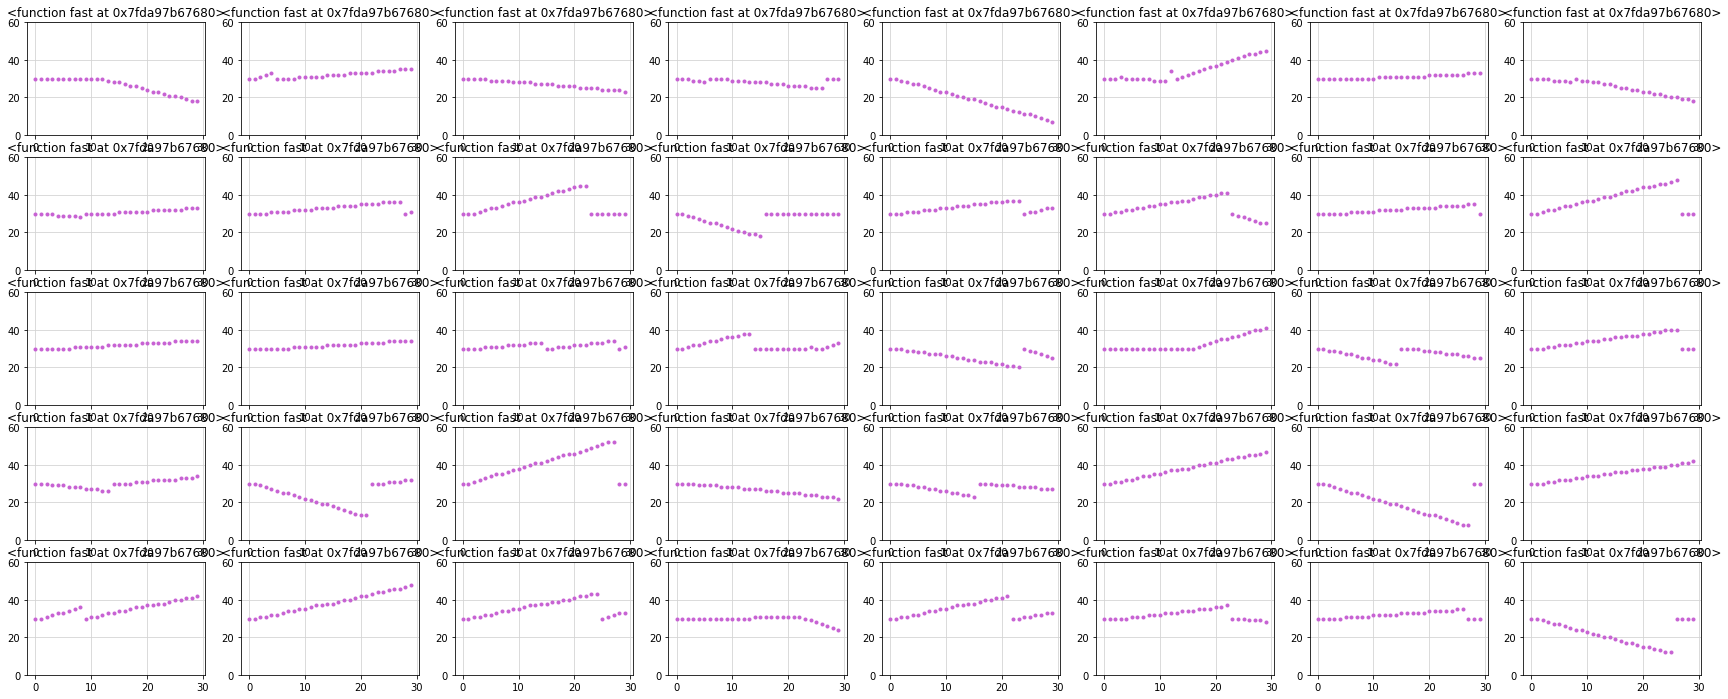

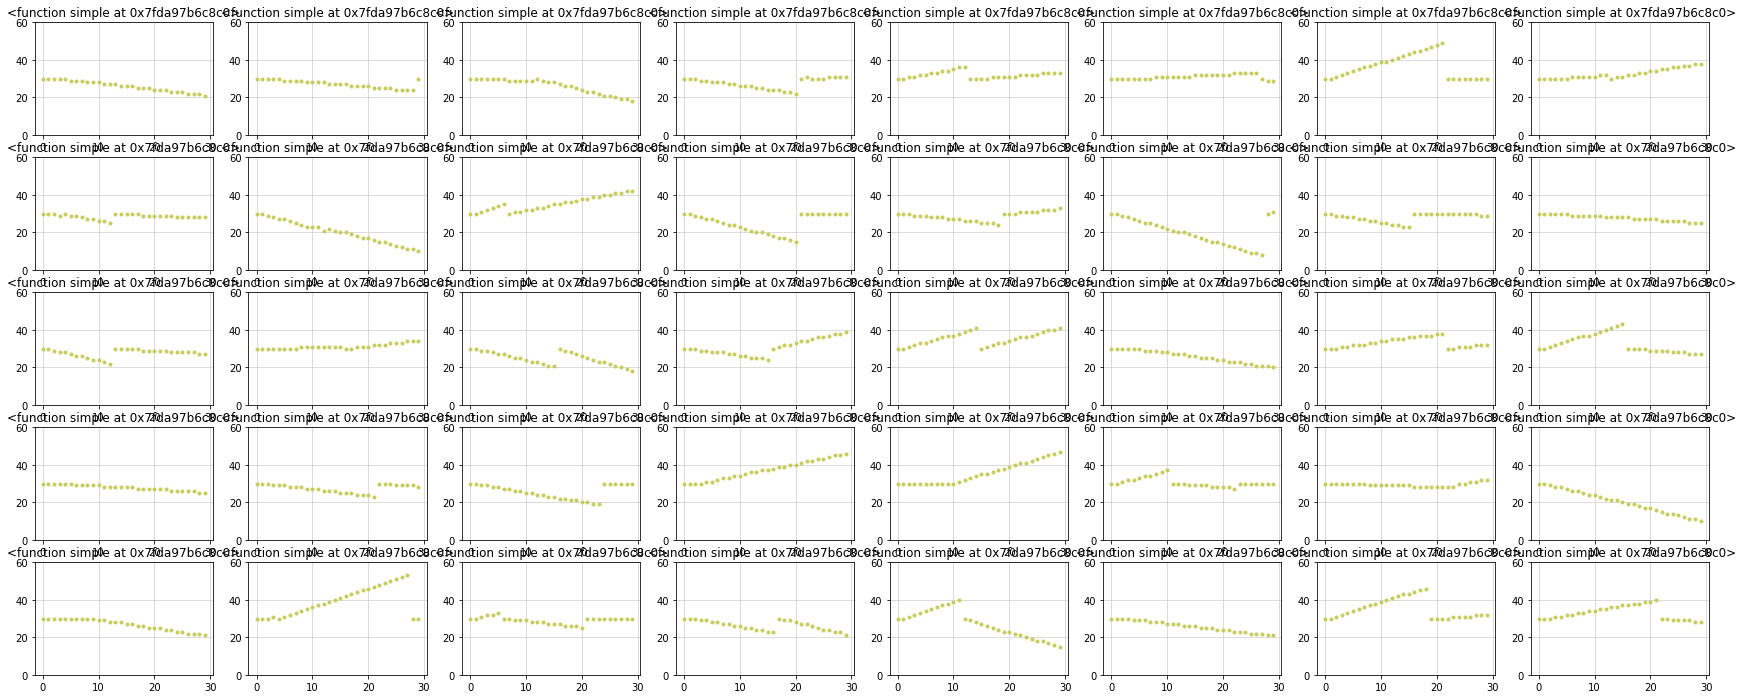

In [8]:
n_samples=30
batch_size=40

def plotit(generated, name):
    color = np.random.rand(3,)
    plt.subplots(figsize=(30, 12))
    for i in range(batch_size):
        plt.subplot(5, 8, i+1)
        plt.ylim(0, p.n_classes)
        plt.grid(color='lightgray')
        plt.title(name)
        plt.plot(torch.arange(n_samples), generated[i, 0].cpu(), '.', color=color)


for f in [sample.fast, sample.simple]:
    y, logits, *_ = f(m, ds.transforms, utils.decode_random, n_samples=n_samples, batch_size=batch_size)
    plotit(y, str(f))